In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import time
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.tsv', 'test_stg2.tsv', 'sample_submission.csv', 'test.tsv', 'sample_submission_stg2.csv']


Data Preprocessing

Data Loading

In [2]:
start_time = time.time()
train = pd.read_table('../input/train.tsv', engine='c')
test = pd.read_table('../input/test.tsv', engine='c')
print('[{}] Finished to load data'.format(time.time() - start_time))
print('Train shape: ', train.shape)
print('Test shape: ', test.shape)
nrow_train = train.shape[0]
Y = np.log1p(train["price"])
train.head(5)

[7.90633225440979] Finished to load data
Train shape:  (1482535, 8)
Test shape:  (693359, 7)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [3]:
# handling missing values
def handle_missing(dataset):
    dataset['brand_name'].fillna(value='no brand', inplace=True)
    dataset['item_description'].fillna(value='no description', inplace=True)
# deriving new features 
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")
#  Encoding feature values
def encoding(train):
    lb_make = LabelEncoder()
    train['brand_name_code'] = lb_make.fit_transform(train['brand_name'])
    train['sub_cat1_code'] = lb_make.fit_transform(train['sub_cat1'])
    train['sub_cat2_code'] = lb_make.fit_transform(train['sub_cat2'])
    X_brand = pd.concat([train['brand_name_code'],train['sub_cat1_code'],train['sub_cat2_code']], axis=1, sort=False)
    return X_brand

>  exploratory data analysis

In [4]:
train_copy = train
# splitting category column into three sub categories
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")
train_copy['general_cat'], train_copy['sub_cat1'], train_copy['sub_cat2']= zip(*train_copy['category_name'].apply(lambda x: split_cat(x)))

In [5]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 11 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
general_cat          1482535 non-null object
sub_cat1             1482535 non-null object
sub_cat2             1482535 non-null object
dtypes: float64(1), int64(3), object(7)
memory usage: 124.4+ MB


In [6]:
train_copy.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


checking for null values in the dataset

In [7]:
print(train_copy.apply(lambda x: sum(x.isnull()), axis=0))
#print(train_copy.isnull().values.sum())

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
general_cat               0
sub_cat1                  0
sub_cat2                  0
dtype: int64


In [8]:
train_copy.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

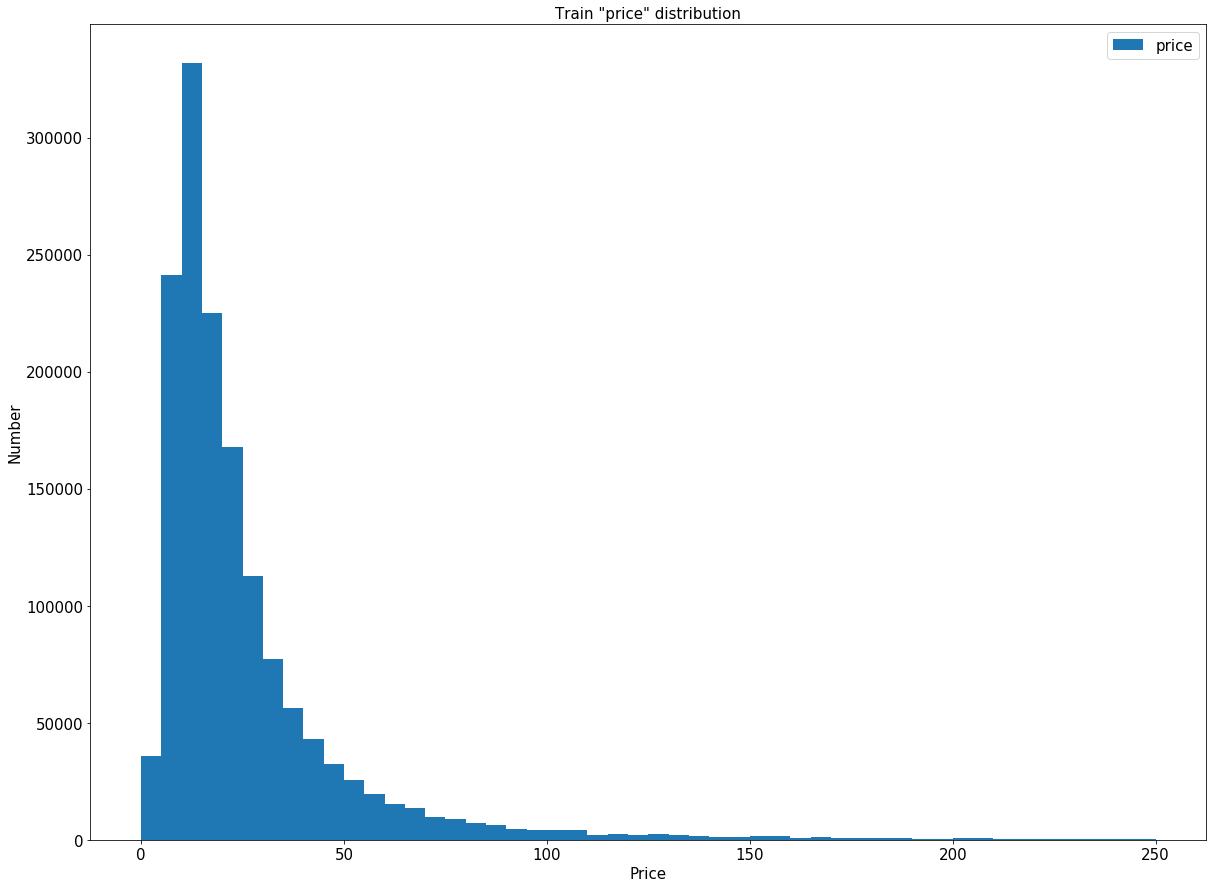

In [9]:
# Price distribution
plt.figure(figsize=(20, 15))
plt.hist(train_copy['price'], bins=50, range=[0,250], label='price')
plt.title('Train "price" distribution', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('Number', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

Price is not normally distributed. So we apply log to get normal distribution

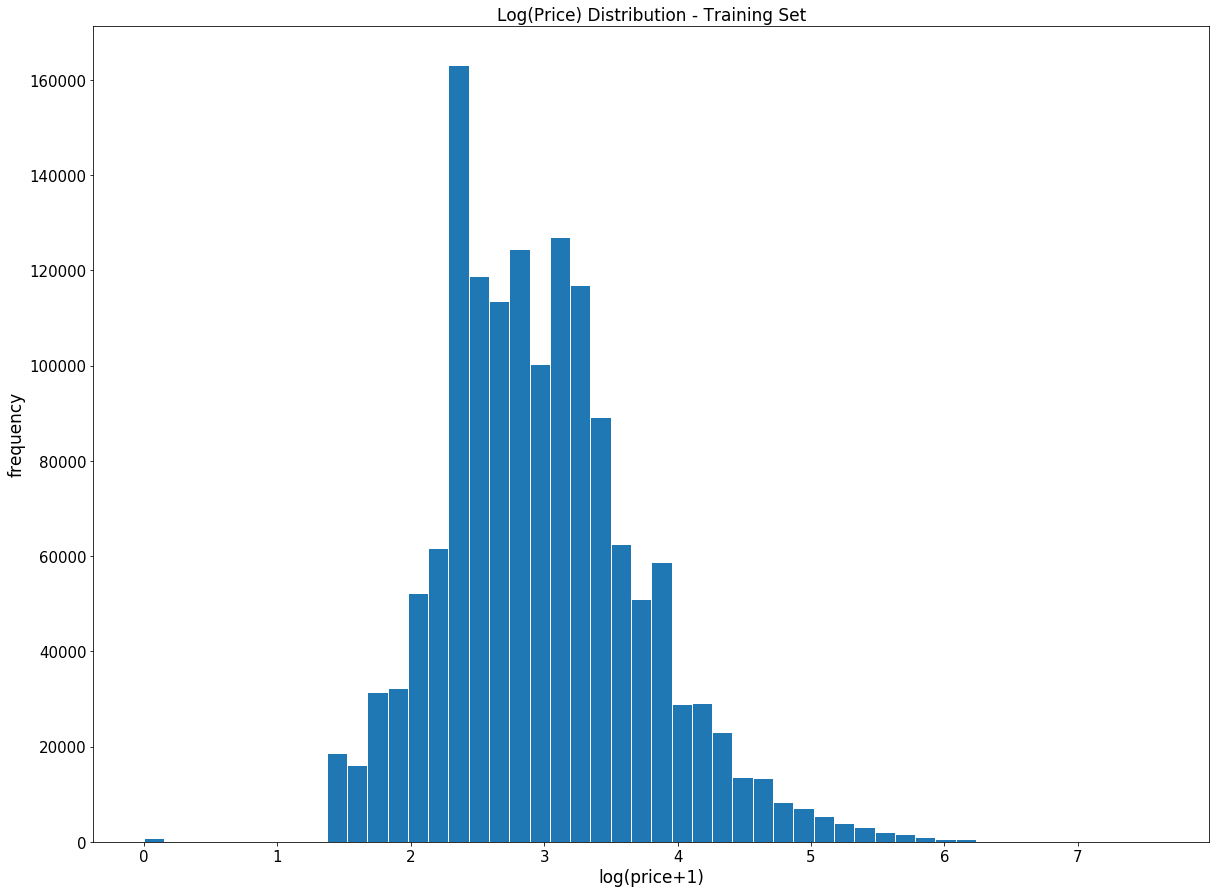

In [10]:
# log Price distribution
plt.figure(figsize=(20, 15))
np.log(train['price']+1).plot.hist(bins=50, edgecolor='white')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price) Distribution - Training Set', fontsize=17)
plt.show()

Box Plot to see outliers

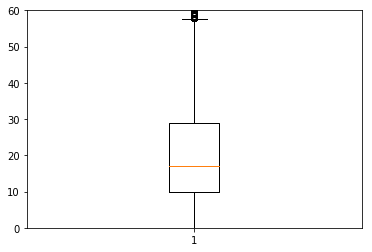

In [11]:
#plt.figure(figsize=(50, 20))
plt.boxplot(train_copy['price'])
plt.ylim(0, 60)
plt.show()

In [12]:
labels = train['general_cat'].astype('category').cat.categories.tolist()
labels

['Beauty',
 'Electronics',
 'Handmade',
 'Home',
 'Kids',
 'Men',
 'No Label',
 'Other',
 'Sports & Outdoors',
 'Vintage & Collectibles',
 'Women']

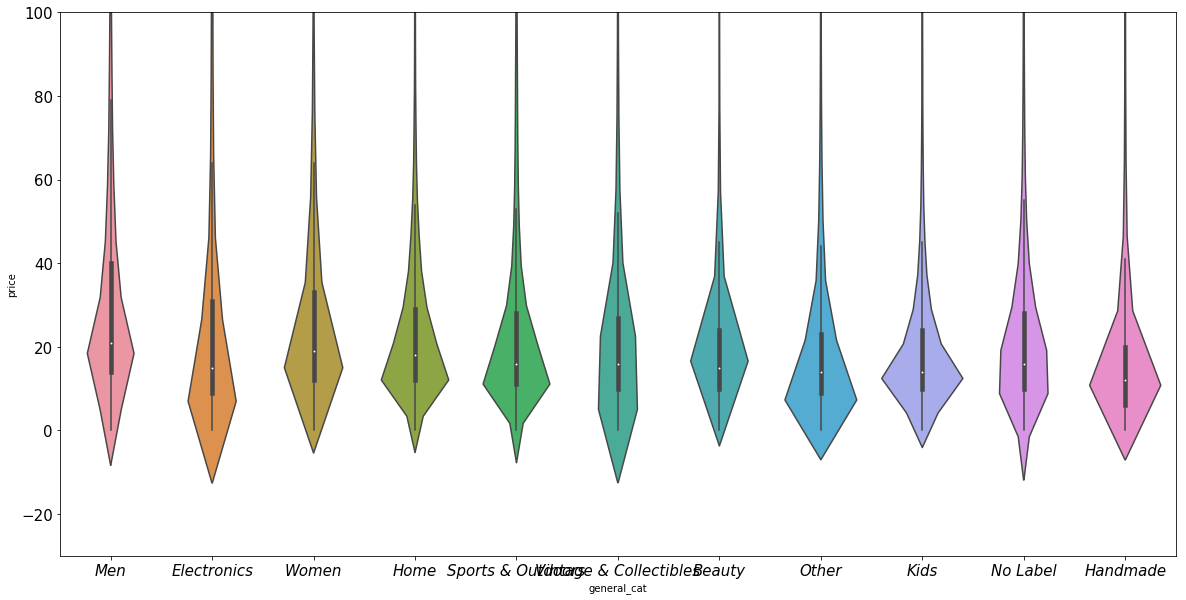

In [13]:
plt.figure(figsize=(20, 10))
sns.violinplot(x='general_cat',y='price',data=train_copy)
plt.ylim(-30, 100)
#plt.xlim(0,13)
plt.xticks(fontsize=15,style='oblique')
plt.yticks(fontsize=15)
plt.show()

In [14]:
merge: pd.DataFrame = pd.concat([train, test])
submission: pd.DataFrame = test[['test_id']]
del train_copy
del train
del test
gc.collect()

merge['general_cat'], merge['sub_cat1'], merge['sub_cat2']= zip(*merge['category_name'].apply(lambda x: split_cat(x)))
handle_missing(merge)
X_brand = encoding(merge)
cv = CountVectorizer(min_df=10)
X_name = cv.fit_transform(merge['name'])
tv = TfidfVectorizer(max_features=3,
                     ngram_range=(1, 3),
                     stop_words='english')
X_description = tv.fit_transform(merge['item_description'])
X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping','general_cat']],
                                      sparse=True).values)
sparse_merge = hstack((X_dummies, X_description, X_brand, X_name)).tocsr()

In [15]:
X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_train:]
print(Y.shape)
print(X.shape)

(1482535,)
(1482535, 21276)


In [16]:
from sklearn.model_selection import train_test_split
train_sparse_matrix, valid_sparse_matrix, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=144)
d_train = lgb.Dataset(train_sparse_matrix, label=y_train)
#d_valid = lgb.Dataset(valid_sparse_matrix, label=y_valid)
params ={ 'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 4,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE'}
classifier = lgb.train( params, train_set=d_train, num_boost_round=3200, verbose_eval=100)
predictions= classifier.predict(valid_sparse_matrix)

pred=[]
for prediction in predictions:
    if prediction<0:
        prediction=0
    pred.append(float(prediction))
predNP=np.array(pred)
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y0), 2)))
print(rmsle(y_valid, predNP))


0.1240580044760247


In [17]:
print("predictions on test data")
test_pred= classifier.predict(X_test)
pred=[]
for prediction in test_pred:
    if prediction<0:
        prediction=0
    pred.append(float(prediction))
predNP=np.array(pred)
submission['price'] = np.expm1(predNP)
submission.to_csv("submission_lgbm.csv", index=False)
print("submission done")

predictions on test data
submission done
